In [305]:
%load_ext autoreload
%autoreload 2

import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter.RaymondFilters import RaymondFilter6, RaymondFilter10

import cartopy.crs as ccrs
import cartopy.feature as cfeature

klevels = [23,24,25,26,27]

klevel  = 25


RRFS0 = ("/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/ctrl/region_202105261200_F%2.2i.nc" % (utc-12))
RRFS1 = ("/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/region_202105261200_F%2.2i.nc" % (utc-12))

HRRR_dir  = "/Users/Louis.Wicker/CAM_Case_Studies/20210526/HRRR/"
RRFS0_dir = "/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/ctrl/"
RRFS1_dir = "/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/"

hrrr_dir  = "/Users/Louis.Wicker/CAM_Case_Studies/2020081006/hrrr/"
rrfs0_dir = "/Users/Louis.Wicker/CAM_Case_Studies/2020081006/ctrl/"
rrfs1_dir = "/Users/Louis.Wicker/CAM_Case_Studies/2020081006/nord3/"

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xa.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

hrrr  = open_mfdataset_list(hrrr_dir,  "region_*.nc")
rrfs0 = open_mfdataset_list(rrfs0_dir,  "region_*.nc")
rrfs1 = open_mfdataset_list(rrfs1_dir,  "region_*.nc")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Plot Lat Min: 34.4  Lat Max:  48.5

Plot Lon Min: -100.5  Lon Max:  -83.7


/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


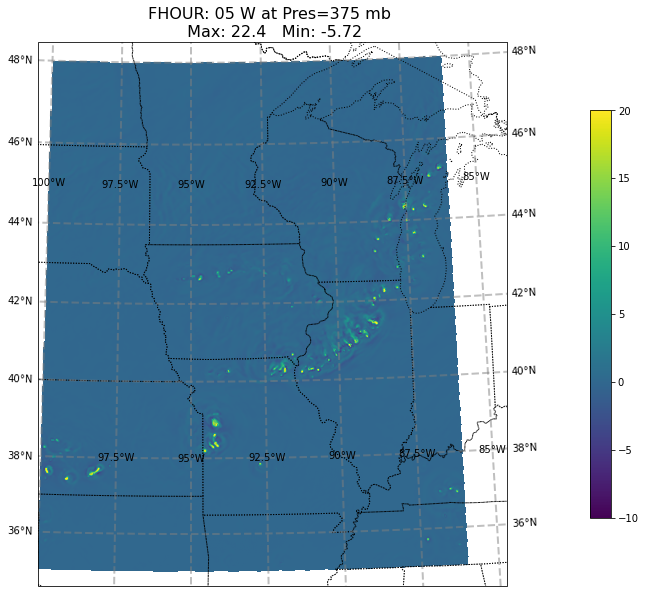

In [327]:
from plot_tools import *

# Set up cartopy stuff here, so the plot routine is already set to use it.

fig, axes = init_cartopy_plot(ncols=1, nrows=1, figsize=(30,10))

# fig, axes = plt.subplots(figsize=(30, 10), ncols=3, 
#         subplot_kw=dict(projection=ccrs.LambertConformal(central_latitude = 30, central_longitude = -95., standard_parallels = (20,20))))

# for ax in axes:
#     ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.STATES, linestyle=':')        

# Plot the HRRR data

cb_info = plot_w_from_xarray(hrrr, klevel=klevel, title='HRRR', ax = axes)

# cb_info = plot_w_from_xarray(rrfs0, klevel=klevel, title='ctrl', ax =  axes[1])
# cb_info = plot_w_from_xarray(rrfs1, klevel=klevel, title='nord3', ax = axes[2])


In [205]:
hrrr_w = np.nan_to_num((hrrr.W.values[klevels]).astype('float64'))
#hrrr_w = np.zeros_like(hrrr_w)

hrrrw_w = hrrr_w.mean(axis=0)

rrfs0_w = np.nan_to_num((rrfs0.W.values[klevels]).astype('float64'))
#rrfs0_w = np.zeros_like(rrfs0_w)

rrfs1_w = np.nan_to_num((rrfs1.W.values[klevels]).astype('float64'))
#rrfs1_w = np.zeros_like(rrfs1_w)



----------------------
get_spectra3d called
----------------------


------------------------
get_spectra2d_rad called

get_spectra2d_rad: can only analyze process same wavenumbers in X & Y, nx: 453  ny: 492

get_spectra2d_rad: will sample a square domain using nx/2, ny/2 center point

get_spectra2dr1: Field has [even] dimensions nx: 452  ny: 452

------------------------


------------------------
get_spectra2d_rad called

get_spectra2d_rad: can only analyze process same wavenumbers in X & Y, nx: 453  ny: 492

get_spectra2d_rad: will sample a square domain using nx/2, ny/2 center point

get_spectra2dr1: Field has [even] dimensions nx: 452  ny: 452

------------------------


------------------------
get_spectra2d_rad called

get_spectra2d_rad: can only analyze process same wavenumbers in X & Y, nx: 453  ny: 492

get_spectra2d_rad: will sample a square domain using nx/2, ny/2 center point

get_spectra2dr1: Field has [even] dimensions nx: 452  ny: 452

------------------------


------

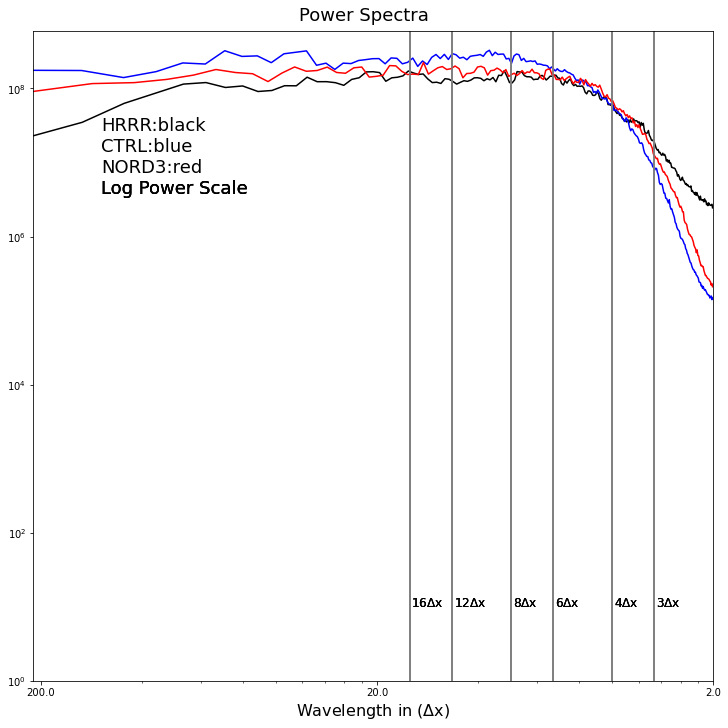

In [213]:
from spectra.py_spectra import *

fig = plt.figure(constrained_layout=True,figsize=(10,10))

ylim = 6e8
axis = 0
func = get_spectra2d_rad

gs = gridspec.GridSpec(1, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

plot_spectra(hrrr_w,  func=func,  axis=axis, ax=[ax1], title='HRRR:black\nCTRL:blue\nNORD3:red', ylim=[1,ylim], loglog=1)
plot_spectra(rrfs0_w, func=func,  axis=axis, ax=[ax1], title='', PScolor='b', ylim=[1,ylim], loglog=1)
plot_spectra(rrfs1_w, func=func,  axis=axis, ax=[ax1], title='', PScolor='r', ylim=[1,ylim], loglog=1)

plt.show()

In [ ]:
from spectra.py_spectra import *

fig = plt.figure(constrained_layout=True,figsize=(20,10))

ylim = 6e8
axis = 0
func = get_spectra2d_rad



gs = gridspec.GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

plot_spectra(f.W.isel(nz=klevel), func=func,  axis=axis, ax=[ax1], title='RAW', ylim=[1,ylim], loglog=1)
plot_spectra(g.W.isel(nz=klevel), ax=[ax1], func=func, axis=axis, title='', PScolor='r', loglog=1, ylim=[1,ylim])
plot_spectra(h.W.isel(nz=klevel), ax=[ax1], func=func, axis=axis, title='', PScolor='b', loglog=1, ylim=[1,ylim])

plot_spectra(fw_tmp2.isel(nz=klevel), func=func, axis=axis, ax=[ax2], title='HIGHPASS', loglog=1, ylim=[1,ylim])
plot_spectra(gw_tmp2.isel(nz=klevel), ax=[ax2], func=func,  axis=axis, title='HIGHPASS',  PScolor='r', loglog=1, ylim=[1,ylim])
plot_spectra(hw_tmp2.isel(nz=klevel), ax=[ax2], func=func,  axis=axis, title='HIGHPASS',  PScolor='b', loglog=1, ylim=[1,ylim])

plt.show()

In [ ]:
# Test 2D filtering with various filters.

from filter.RaymondFilters import RaymondFilter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats

npass = 10
dx    = 12

fw_tmp2 = RaymondFilter(fw_tmp, dx, npass = npass, highpass=True, klevels = [klevel])
    
fw_tmp2 = f.W.copy(data=(fw_tmp2))

gw_tmp2 = RaymondFilter(gw_tmp, dx, npass = npass, highpass=True,klevels = [klevel])

gw_tmp2 = g.W.copy(data=(gw_tmp2))

hw_tmp2 = RaymondFilter(hw_tmp, dx, npass = npass, highpass=True,klevels = [klevel])

hw_tmp2 = h.W.copy(data=(hw_tmp2))

